![](../assets/images/construction.gif)

# Journey 4
## Part 1


### Transfer Learning 

This is simply where we train a network for one task and then use some or all of that learning in a different task.

In [62]:
from os import listdir
from os.path import isdir, isfile, join
import re
import random
import re
import os
import sys

import numpy as np
from PIL import Image

In [2]:
DATA_DIR = '../data/fruits-360-data/fruits-360'
TEST_DATA = DATA_DIR + '/Test'
TRAIN_DATA = DATA_DIR + '/Training'

In [3]:
#
# Create a one-hot encoding for the given list
#
def create_one_hot_encoding_dicts(list_to_encode):
    list_to_one_hot = dict()
    one_hot_to_item = dict()
    for i, l in enumerate(list_to_encode):
        oh = np.zeros((len(list_to_encode)))
        oh[i] = 1
        list_to_one_hot[l] = oh
        one_hot_to_item[np.array2string(oh)] = l
    return list_to_one_hot, one_hot_to_item

In [4]:
#
# Return a list of only the JPG files for a given dir
#
def list_files(data_dir):
    jpg_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and re.search('\.jpg$',f,flags=re.IGNORECASE)]
    return jpg_files

In [5]:
#
# Load a given list of fruits from the selected data set location
#
def load_data(fruits_to_get, 
              test_data_dir,
              train_data_dir
             ):
    
    one_hot_dict, item_dict = create_one_hot_encoding_dicts(fruits_to_get)
        
    test_data = []
    train_data = []
    
    for fruit in fruits_to_get:
        
        test_fruit_dir = test_data_dir + "/" + fruit
        train_fruit_dir = train_data_dir + "/" + fruit
        
        if isdir(test_fruit_dir) and isdir(train_fruit_dir):
            one_hot_val = one_hot_dict[fruit]
            
            print("loading [" + fruit + "]" + " one hot: " + str(one_hot_val))
            
            print('Test Data')
            for img_file in list_files(test_fruit_dir):
                test_data.append([np.array(Image.open(join(test_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            print('Training Data')
            for img_file in list_files(train_fruit_dir):
                train_data.append([np.array(Image.open(join(train_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            img_shape = test_data[0][0].shape
            one_hot_shape = test_data[0][1].shape
            
            # Convert data to numpy
            x_test = np.zeros((len(test_data), *img_shape))
            y_test = np.zeros((len(test_data), one_hot_shape[0]))
            x_train = np.zeros((len(train_data), *img_shape))
            y_train = np.zeros((len(train_data), one_hot_shape[0]))
            
            i = 0 
            rnd_idx = random.sample(range(0, len(test_data)), len(test_data))
            for img, one_hot in test_data:
                x_test[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_test[rnd_idx[i]] = one_hot
                i += 1

            i = 0 
            rnd_idx = random.sample(range(0, len(train_data)), len(train_data))
            for img, one_hot in train_data:
                x_train[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_train[rnd_idx[i]] = one_hot
                i += 1

        else:
            raise Exception("Cannot load unknown fruit - missing from test and/or train data set[" + fruit + "]")
            
    return x_train, \
           y_train, \
           x_test, \
           y_test, \
           one_hot_dict, \
           item_dict
        

In [6]:
list_to_get = ["Apple Golden 1",
               "Apple Golden 2",
               "Apple Golden 3",
               "Apple Red 1",
               "Apple Red 2",
               "Apple Red 3"]              
x_train, y_train, x_test, y_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

loading [Apple Golden 1] one hot: [1. 0. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
loading [Apple Golden 2] one hot: [0. 1. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
.....................

In [7]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
        

(961, 100, 100, 3)
(961, 6)
(2878, 100, 100, 3)
(2878, 6)


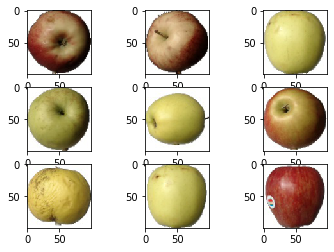

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], interpolation='none')

In [9]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14459103540239111041
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4944779673
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8330430948260699690
physical_device_desc: "device: 0, name: GeForce GTX TITAN Z, pci bus id: 0000:04:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 4944779673
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8357476283266526180
physical_device_desc: "device: 1, name: GeForce GTX TITAN Z, pci bus id: 0000:05:00.0, compute capability: 3.5"
]


In [11]:
def build_cnn_layers(model_name,
                     input_shape):
    cnn_in = Input(shape=input_shape, name = "cnn0Input")
    cnn_l1 = Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', name = "cnn1_Conv2d")(cnn_in) 
    cnn_l2 = MaxPooling2D(pool_size=(2, 2), name = "cnn2_MaxPool2D")(cnn_l1)
    cnn_l3 = BatchNormalization(name = "cnn3_BatchNorm")(cnn_l2) 
    cnn_l4 = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', name = "cnn3_conv2d")(cnn_l3)
    cnn_l5 = MaxPooling2D(pool_size=(2, 2), name = "cnn5_MaxPool2D")(cnn_l4)
    cnn_l6 = BatchNormalization(name = "cnn6_BatchNorm")(cnn_l5) 
    cnn_l7 = Dropout(rate=0.25,name = "cnn7_Dropout")(cnn_l6) 
    cnn_out = Flatten(name = "cnnOutput_Flatten")(cnn_l7)
    return cnn_in, cnn_out

In [12]:
def build_classifier_layers(model_name,
                            num_classes,
                            input_layer):
    cl_l1 = Dense(500, activation='relu', name = "clInput_Dense")(input_layer)
    cl_l2 = Dropout(rate=0.25, name = "cl1_Dropout")(cl_l1)
    cl_out = Dense(num_classes, activation='softmax', name = "clOutput")(cl_l2)
    return cl_out

In [13]:
def create_model(model_name,
                input_shape,
                num_classes):
    model_cnn_in, model_cnn_out = build_cnn_layers(model_name, input_shape)
    model_cl_out = build_classifier_layers(model_name, num_classes, model_cnn_out)

    model = Model(inputs=[model_cnn_in],outputs=[model_cl_out])
    model.name = model_name
    return model

In [14]:
input_shape = (100, 100, 3)
num_classes = 6
model_name = "classifier_" + str(num_classes)

model = create_model(model_name, input_shape, num_classes)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn0Input (InputLayer)       (None, 100, 100, 3)       0         
_________________________________________________________________
cnn1_Conv2d (Conv2D)         (None, 96, 96, 16)        1216      
_________________________________________________________________
cnn2_MaxPool2D (MaxPooling2D (None, 48, 48, 16)        0         
_________________________________________________________________
cnn3_BatchNorm (BatchNormali (None, 48, 48, 16)        64        
_________________________________________________________________
cnn3_conv2d (Conv2D)         (None, 23, 23, 32)        4640      
_________________________________________________________________
cnn5_MaxPool2D (MaxPo

In [20]:
def model_compile(model):
    model = multi_gpu_model(model, gpus=2)
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(lr=0.01),
                  metrics=['accuracy'])
    return model

In [21]:
model = model_compile(model)

In [22]:
batch_size = 32
num_epochs = 30
history = model.fit(x_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, y_test)
                    )

Instructions for updating:
Use tf.cast instead.
Train on 2878 samples, validate on 961 samples
Epoch 1/30
2878/2878 [==============================] - 11s 4ms/step - loss: 0.5101 - acc: 0.8384 - val_loss: 0.3397 - val_acc: 0.8626
Epoch 2/30
2878/2878 [==============================] - 2s 808us/step - loss: 0.0555 - acc: 0.9878 - val_loss: 0.0208 - val_acc: 0.9990
Epoch 3/30
2878/2878 [==============================] - 2s 775us/step - loss: 0.0247 - acc: 0.9955 - val_loss: 0.0162 - val_acc: 0.9990
Epoch 4/30
2878/2878 [==============================] - 2s 774us/step - loss: 0.0153 - acc: 0.9976 - val_loss: 0.0138 - val_acc: 0.9990
Epoch 5/30
2878/2878 [==============================] - 2s 774us/step - loss: 0.0106 - acc: 0.9979 - val_loss: 2.9312 - val_acc: 0.6191
Epoch 6/30
2878/2878 [==============================] - 2s 779us/step - loss: 0.0248 - acc: 0.9920 - val_loss: 0.0077 - val_acc: 0.9990
Epoch 7/30
2878/2878 [==============================] - 2s 769us/step - loss: 0.0065 - acc

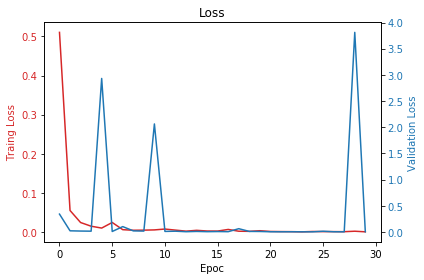

In [23]:
epocs = np.arange(0,num_epochs,1)

fig, ax1 = plt.subplots()
plt.title('Loss')

color = 'tab:red'
ax1.set_xlabel('Epoc')
ax1.set_ylabel('Traing Loss', color=color)
ax1.plot(epocs, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(epocs, history.history['val_loss'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

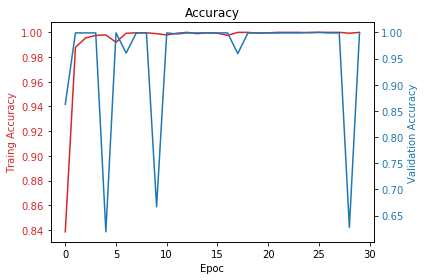

In [24]:
epocs = np.arange(0,num_epochs,1)

fig, ax1 = plt.subplots()
plt.title('Accuracy')

color = 'tab:red'
ax1.set_xlabel('Epoc')
ax1.set_ylabel('Traing Accuracy', color=color)
ax1.plot(epocs, history.history['acc'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(epocs, history.history['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [44]:
def test_model_prediction(model,
                          x_test_set, 
                          y_test_set,
                          num_to_test,
                          summary = False):
    num_passed = 0
    list_to_test = np.random.randint(len(x_test_set), size=num_to_test)

    for i in list_to_test:
        xt = x_test_set[i]
        xt = np.reshape(xt,(1,100,100,3))
        if(np.argmax(model.predict(xt)) == np.argmax(y_test_set[i])):
            print("Correct Prediction for x_test element: " + str(i))
            num_passed += 1
        else:
            print("Failed Prediction for x_test element: " + str(i))
    print("\nOverall Score : "+ str(round(num_passed/num_to_test,1)*100)+"%")
    return

In [45]:
test_model_prediction(model, x_test, y_test, 10)

Correct Prediction for x_test element: 413
Correct Prediction for x_test element: 118
Correct Prediction for x_test element: 125
Correct Prediction for x_test element: 595
Correct Prediction for x_test element: 879
Correct Prediction for x_test element: 362
Correct Prediction for x_test element: 364
Correct Prediction for x_test element: 509
Correct Prediction for x_test element: 218
Correct Prediction for x_test element: 178

Overall Score : 100.0%


In [28]:
list_to_get = ["Apple Braeburn"]              
x1_train, y1_train, x1_test, y1_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

loading [Apple Braeburn] one hot: [1.]
Test Data
....................................................................................................................................................................
Training Data
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [29]:
# 

In [42]:
test_model_prediction(model, x1_test, y1_test, 10)

Failed Prediction for x_test element: 47
Failed Prediction for x_test element: 71
Failed Prediction for x_test element: 96
Failed Prediction for x_test element: 49
Failed Prediction for x_test element: 37
Failed Prediction for x_test element: 160
Failed Prediction for x_test element: 52
Failed Prediction for x_test element: 147
Failed Prediction for x_test element: 66
Failed Prediction for x_test element: 52

Overall Score : 0.0%


In [31]:
cnn_weights = model.get_weights()

In [32]:
for i, w in enumerate(cnn_weights):
    print(str(i) + ' : ' + str(w.shape))

0 : (5, 5, 3, 16)
1 : (16,)
2 : (16,)
3 : (16,)
4 : (3, 3, 16, 32)
5 : (32,)
6 : (32,)
7 : (32,)
8 : (3872, 500)
9 : (500,)
10 : (500, 6)
11 : (6,)
12 : (16,)
13 : (16,)
14 : (32,)
15 : (32,)


In [33]:
def model_layers(model):
    try:
        layers = model.get_layer(model_name).layers
    except:
        layers = model.layers
        
    return layers

In [34]:
# Model strcuture changes when complied for GPU, so we need to look in diffent places for the 'actual' layers
def aij_model_summary(model):
    
    for l in model_layers(model):
        print(l.name+":: params #"+str(l.count_params()))
    return

In [35]:
aij_model_summary(model)

cnn0Input:: params #0
cnn1_Conv2d:: params #1216
cnn2_MaxPool2D:: params #0
cnn3_BatchNorm:: params #64
cnn3_conv2d:: params #4640
cnn5_MaxPool2D:: params #0
cnn6_BatchNorm:: params #128
cnn7_Dropout:: params #0
cnnOutput_Flatten:: params #0
clInput_Dense:: params #1936500
cl1_Dropout:: params #0
clOutput:: params #3006


## Articles of Interest

[gpu article 1](https://datascience.stackexchange.com/questions/23895/multi-gpu-in-keras)
[Keras Conv2D](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

In [36]:
# Model strcuture changes when complied for GPU, so we need to look in diffent places for the 'actual' layers
cnn_only = ".*cnn.*"
def aij_save_cnn_layers(model,
                        pattern=".*"):

    for l in model_layers(model):
        l_name = l.name
        if re.search(pattern, l_name):
            w = l.get_weights()
            print('Saving Layer :'+ l.name + ":: params #"+str(l.count_params()))
            np.save(l_name + '.npy', w, allow_pickle=True)
    return

In [37]:
aij_save_cnn_layers(model, pattern= ".*")

Saving Layer :cnn0Input:: params #0
Saving Layer :cnn1_Conv2d:: params #1216
Saving Layer :cnn2_MaxPool2D:: params #0
Saving Layer :cnn3_BatchNorm:: params #64
Saving Layer :cnn3_conv2d:: params #4640
Saving Layer :cnn5_MaxPool2D:: params #0
Saving Layer :cnn6_BatchNorm:: params #128
Saving Layer :cnn7_Dropout:: params #0
Saving Layer :cnnOutput_Flatten:: params #0
Saving Layer :clInput_Dense:: params #1936500
Saving Layer :cl1_Dropout:: params #0
Saving Layer :clOutput:: params #3006


In [74]:
# Model strcuture changes when complied for GPU, so we need to look in diffent places for the 'actual' layers
def aij_load_cnn_layers(model,
                        pattern = ".*",
                        trainable = True):
    
    for l in model_layers(model):
        try:
            if re.search(pattern, l.name):
                w = np.load(l.name+'.npy',allow_pickle=True)
                l.set_weights(w)
                l.trainable = trainable
                print("Loaded weights for Layer: "+l.name)
            else:
                print("Ignored Layer:" + l.name + " as it does not match load pattern")
        except IOError as e:
            print("No loadable weights for Layer: "+l.name) 
        except:
            print("Unexpected error:", sys.exc_info()[0])
    return

In [75]:
# Test we can create a new 6 classifer model and re load
input_shape = (100, 100, 3)
num_classes = 6
model_name = "classifier_reload_test" + str(num_classes)

model_reload_test = create_model(model_name, input_shape, num_classes)
model_reload_test = model_compile(model_reload_test)
aij_model_summary(model_reload_test)


cnn0Input:: params #0
cnn1_Conv2d:: params #1216
cnn2_MaxPool2D:: params #0
cnn3_BatchNorm:: params #64
cnn3_conv2d:: params #4640
cnn5_MaxPool2D:: params #0
cnn6_BatchNorm:: params #128
cnn7_Dropout:: params #0
cnnOutput_Flatten:: params #0
clInput_Dense:: params #1936500
cl1_Dropout:: params #0
clOutput:: params #3006


In [76]:
test_model_prediction(model_reload_test, x_test, y_test, 10)

Failed Prediction for x_test element: 362
Correct Prediction for x_test element: 246
Correct Prediction for x_test element: 19
Failed Prediction for x_test element: 39
Failed Prediction for x_test element: 254
Failed Prediction for x_test element: 729
Failed Prediction for x_test element: 562
Failed Prediction for x_test element: 382
Failed Prediction for x_test element: 766
Failed Prediction for x_test element: 346

Overall Score : 20.0%


In [77]:
aij_load_cnn_layers(model_reload_test)
model = model_compile(model)

Loaded weights for Layer: cnn0Input
Loaded weights for Layer: cnn1_Conv2d
Loaded weights for Layer: cnn2_MaxPool2D
Loaded weights for Layer: cnn3_BatchNorm
Loaded weights for Layer: cnn3_conv2d
Loaded weights for Layer: cnn5_MaxPool2D
Loaded weights for Layer: cnn6_BatchNorm
Loaded weights for Layer: cnn7_Dropout
Loaded weights for Layer: cnnOutput_Flatten
Loaded weights for Layer: clInput_Dense
Loaded weights for Layer: cl1_Dropout
Loaded weights for Layer: clOutput


In [78]:
test_model_prediction(model_reload_test, x_test, y_test, 10)

Correct Prediction for x_test element: 934
Correct Prediction for x_test element: 557
Correct Prediction for x_test element: 424
Correct Prediction for x_test element: 388
Correct Prediction for x_test element: 138
Correct Prediction for x_test element: 410
Correct Prediction for x_test element: 709
Correct Prediction for x_test element: 16
Correct Prediction for x_test element: 692
Correct Prediction for x_test element: 871

Overall Score : 100.0%


In [82]:
input_shape = (100, 100, 3)
num_classes = 7
model_name = "classifier_" + str(num_classes)

model_7_classes = create_model(model_name, input_shape, num_classes)

print(model_7_classes.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn0Input (InputLayer)       (None, 100, 100, 3)       0         
_________________________________________________________________
cnn1_Conv2d (Conv2D)         (None, 96, 96, 16)        1216      
_________________________________________________________________
cnn2_MaxPool2D (MaxPooling2D (None, 48, 48, 16)        0         
_________________________________________________________________
cnn3_BatchNorm (BatchNormali (None, 48, 48, 16)        64        
_________________________________________________________________
cnn3_conv2d (Conv2D)         (None, 23, 23, 32)        4640      
_________________________________________________________________
cnn5_MaxPool2D (MaxPooling2D (None, 11, 11, 32)        0         
_________________________________________________________________
cnn6_BatchNorm (BatchNormali (None, 11, 11, 32)        128       
__________

In [83]:
# Need to recompile model after load
aij_load_cnn_layers(model_7_classes, pattern = "cnn.*")


Loaded weights for Layer: cnn0Input
Loaded weights for Layer: cnn1_Conv2d
Loaded weights for Layer: cnn2_MaxPool2D
Loaded weights for Layer: cnn3_BatchNorm
Loaded weights for Layer: cnn3_conv2d
Loaded weights for Layer: cnn5_MaxPool2D
Loaded weights for Layer: cnn6_BatchNorm
Loaded weights for Layer: cnn7_Dropout
Loaded weights for Layer: cnnOutput_Flatten
Ignored Layer:clInput_Dense as it does not match load pattern
Ignored Layer:cl1_Dropout as it does not match load pattern
Ignored Layer:clOutput as it does not match load pattern


In [84]:
model_7_classes = model_compile(model_7_classes)

In [86]:
print(y_test.shape)

(961, 6)


In [89]:
sh = y_test.shape
y_test_7c = np.zeros((sh[0], sh[1]+1))
print(y_test_7c.shape)
y_test_7c[:,:-1] = y_test

(961, 7)


In [91]:
print(y_test_7c[0])


[0. 0. 1. 0. 0. 0. 0.]
